# Markov graph clustering

### Importing libraries

In [78]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
# Networkx for plotting the graph
import networkx as nx
# Define size of the plotted figure
plt.figure(num=None, figsize=(18.0, 14.0), dpi=580, facecolor='w', edgecolor='k')

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
print 'All libraries loaded.'

All libraries loaded.


### Define utility functions

In [79]:
############ Utility functions ############

# Normalization function
def normalize(X):
    return X / X.sum(axis=0)[np.newaxis, :]

# Prune out values that are really close to zero
def prune(X):
    for index in np.ndindex(X.shape):
        value = X[index]
        if value <= pruning_threshold:
            X[index] = 0
    return X

# Compare the 2 matrices to check for convergence
def hasConverged(X, Y):
    # Check if the matrices are equal with a tolerance of 0.001
    
    converged = True
    for i in range(0, X.shape[0]):
        for j in range(0, X.shape[1]):
            if abs(X[i][j] - Y[i][j]) > convergence_tolerance:
                converged = False
                break

#   return np.allclose(X, Y, atol=convergence_tolerance)
    return converged

# Given a transitional matrix, identify and return clusters
def identifyClusters(T):
    clusters = []
    X = (T>pruning_threshold)

    for i in range(0, X.shape[0]):
        if X[i][i]:
            # X[i] is an attractor. All nodes attracted to it form a cluster
            newCluster = [index+1 for index, x in enumerate(T[i,:]) if x>0]
            clusters.append(newCluster)

    return clusters

# Load data from file and create an adjacency matrix
def getAdjacencyMatrixFromDataset(filePath, delimiter=' ', datatype=int):
    
    # Read from the file
    edges = np.loadtxt(filePath, delimiter=delimiter, dtype=datatype)
    
    # We need to recalibrate the node indexes to go from 1 to N
    edgeMap = dict((key, value+1) for (value, key) in enumerate(np.unique(edges)))
    
    edges_recalibrated = []
    for pair in edges:
        edges_recalibrated.append((edgeMap.get(pair[0]), edgeMap.get(pair[1])))
    edges = np.array(edges_recalibrated)
        
    # Initialize the adjacency matrix A
    numOfNodes = int(np.amax(edges))
    A = np.zeros((numOfNodes, numOfNodes))
    
    for line in edges:
        A[line[0]-1][line[1]-1] = 1
        A[line[1]-1][line[0]-1] = 1
        
    return A, edges

### Functions for drawing graphs
##### To be moved below later

In [80]:
# Graph drawing functions
def draw_graph(graph, labels=None, graph_layout='spring',
               node_size=800, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'circular':
        graph_pos=nx.circular_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    elif graph_layout == 'graphviz':
        graph_pos=nx.graphviz_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    if labels is None:
        labels = range(len(graph))

    # show graph
    plt.show()
    
def draw_graph2(G, A, cluster_map):
    import networkx as nx
    import matplotlib.pyplot as plt

    clust_map = {}
    for k, vals in cluster_map.items():
        for v in vals:
            clust_map[v] = k

    colors = []
    for i in range(len(G.nodes())):
        colors.append(clust_map.get(i, 100))

    pos = nx.spring_layout(G)

    from matplotlib.pylab import matshow, show, cm
    plt.figure(2)
    nx.draw_networkx_nodes(G, pos,node_size = 200, node_color =colors , cmap=plt.cm.Blues )
    nx.draw_networkx_edges(G,pos, alpha=0.5)
    matshow(A, fignum=1, cmap=cm.gray)
    plt.show()
    show()

### Reading from the datasets

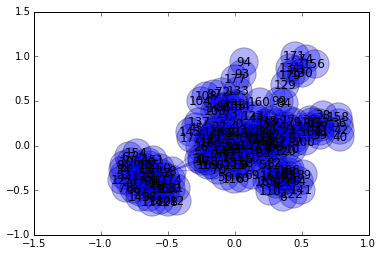

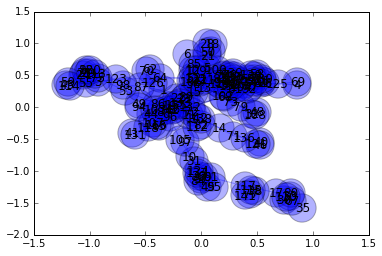

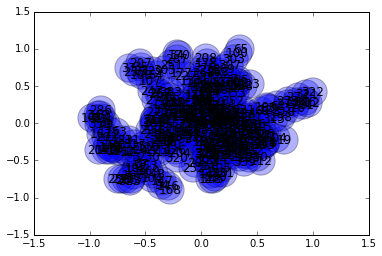

In [81]:
# A = getAdjacencyMatrixFromDataset("dataset/small2.txt")

# AT & T dataset
A_att, edges_att = getAdjacencyMatrixFromDataset("dataset/attweb_net.txt")
# Physics collaborations
A_physics, edges_physics = getAdjacencyMatrixFromDataset("dataset/physics_collaboration_net.txt", datatype='str')
# Yeast metabolic network
A_yeast, edges_yeast = getAdjacencyMatrixFromDataset("dataset/yeast_undirected_metabolic.txt", delimiter='\t')

# Draw graph of original values
draw_graph(edges_att)
draw_graph(edges_physics)
draw_graph(edges_yeast)

In [87]:
######### Configurations for parameters #########
R = 2.0
pruning_threshold = 0.002
matrix_power_parameter = 2
convergence_tolerance = 0.00000001

####### The MCL algorithm implementation ########
def applyMclAlgorithm(A, debug_mode=False):
    M = np.array(A)

    # Add self-loops
    for i in range(0, M.shape[0]):
        M[i][i] = 1
    if debug_mode: print '\nAfter adding self-loops\n', M

    # Normalize
    M = normalize(M)
    if debug_mode: print '\nAfter normalization\n', M

    # Keep an original copy
    originalM = np.array(M)

    count = 1
    maxIterations = 50
    while True:
        if debug_mode: print '\n\n======= Iteration', count, '========'
        previousM = np.array(M)

        # Expand
        M = np.linalg.matrix_power(M, matrix_power_parameter)
        if debug_mode: print '\nExpanding\n', M

        # Inflate
        M = np.power(M, R)
        if debug_mode: print '\nInflating\n', M

        # Re-normalize
        M = normalize(M)
        if debug_mode: print '\nRenormalizing\n', M

        # Pruning
        M = prune(M)
        if debug_mode: print '\nPruning\n', M

        # Check for convergence
        if hasConverged(M, previousM) or count > maxIterations:
            break

        count = count + 1

    if debug_mode: print "\nFinished in", count, "iterations."
    clusters = identifyClusters(M)
    return M, clusters

In [91]:
############# Apply MCL on the datasets #############

M_att, clusters_att = applyMclAlgorithm(A_att)
print '\n..:: AT & T dataset ::..\n\nClusters identified ==> ', len(clusters_att), '\n', clusters_att

M_physics, clusters_physics = applyMclAlgorithm(A_physics)
print '\n..:: Physics collaboration dataset ::..\n\nClusters identified ==> ', len(clusters_physics), '\n', clusters_physics

M_yeast, clusters_yeast = applyMclAlgorithm(A_yeast)
print '\n..:: Yeast metabolic network ::..\n\nClusters identified ==> ', len(clusters_yeast), '\n', clusters_yeast


..:: AT & T dataset ::..

Clusters identified ==>  59 
[[1, 2, 25, 32, 46], [3, 4, 19, 21, 37, 38, 48, 61, 97, 161, 162, 178], [5, 6], [7, 8, 26, 150, 152, 174], [9, 10, 100], [11, 12], [13, 14, 31, 47, 118], [17, 18, 65, 99, 112, 123], [15, 16, 20, 27, 28, 132, 133, 134, 135, 173, 177], [22], [23, 24], [29, 30, 43, 84, 101, 126], [33, 34], [35, 36], [39, 40], [41, 42], [44, 45], [49], [50, 51, 63, 64, 70, 88, 89, 109, 110, 117, 120, 163, 164, 165, 166, 176], [52, 53], [55, 56], [57, 58], [59, 60], [62], [66, 67], [68, 69], [71, 72], [73, 74], [75, 76, 90, 119], [77, 78], [79, 80], [82, 83, 155], [86, 87], [91, 92], [93, 94], [95, 96], [98], [103, 104], [105, 106], [107, 108], [113, 114], [115, 116], [121, 122], [124, 125], [127, 128], [129, 160, 179], [130, 156], [131, 171], [136, 137], [54, 81, 85, 102, 111, 138, 139, 144, 147, 167], [140, 141], [142, 143], [145, 172], [146, 175], [148, 149], [151, 154], [153, 180], [157, 158], [159, 168, 169, 170]]

..:: Physics collaboration datas

In [ ]:
### Alternate algorithm for verification

def normalize(A):
    column_sums = A.sum(axis=0)
    new_matrix = A / column_sums[np.newaxis, :]
    return new_matrix

def inflate(A, inflate_factor):
    return normalize(np.power(A, inflate_factor))

def expand(A, expand_factor):
    return np.linalg.matrix_power(A, expand_factor)

def add_diag(A, mult_factor):
    return A + mult_factor * np.identity(A.shape[0])

def identifyClusters(A):
    clusters = []
    X = (A>0.0)

    for i in range(0, X.shape[0]):
        if X[i][i]:
            # X[i] is an attractor.
            # All nodes attracted to it form a cluster
            newCluster = [index+1 for index, x in enumerate(A[i,:]) if x>0]
            clusters.append(newCluster)

    return clusters

def mcl(M, expand_factor = 2, inflate_factor = 2, max_loop = 20 , mult_factor = 1):
    M = add_diag(M, mult_factor)
    M = normalize(M)

    for i in range(max_loop):
        M = expand(M, expand_factor)        
        M = inflate(M, inflate_factor)
    clusters = identifyClusters(M)
    return M, clusters

M = np.array(A)
M, clusters2 = mcl(M)
print '\n', M
print '\n', clusters2, '\n\n'

flag = True
for i, x in enumerate(clusters):
    if clusters[i] != clusters2[i]:
        flag = False
print 'Are both cluster results equal =====>', flag



In [ ]:
import functools
graph = functools.partial(gv.Graph, format='svg')

def add_nodes(graph, nodes):
    for n in nodes:
        if isinstance(n, tuple):
            graph.node(n[0], **n[1])
        else:
            graph.node(n)
    return graph

def add_edges(graph, edges):
    for e in edges:
        if isinstance(e[0], tuple):
            graph.edge(*e[0], **e[1])
        else:
            graph.edge(*e)
    return graph

g2 = gv.Graph(format='svg')
g2.node('A')
g2.node('B')
g2.node('C')
g2.edges = [
    ('A', 'B'),
    ('B', 'C'),
    (('A', 'C'), {}),
]

g2.render('img/g2')